In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

from Utils.customPipelines import *

from sklearn.metrics import jaccard_score
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
# Load the dataset
file_path = 'Data/Analyst_Coverage.csv'
df = pd.read_csv(file_path)
print(df.shape)
df.sample(15)

(8676, 9)


,ANALYST,DATE,BROKER,RATING,RECOMMENDATION,TARGET_PRICE,BBTICKER,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME
4675,Andobler,2/4/2020,Crsse,3.0,neutral,2.750000e+03,SGSN SW Equity,Industrials,Commercial & Professional Serv
421,MicNovod,2/6/2020,Nodea,5.0,buy,4.720000e+02,NOVOB DC Equity,Health Care,"Pharmaceuticals, Biotechnology"
2402,Andy Chu,2/20/2020,Deank,5.0,buy,4.000000e+01,DPW GR Equity,Industrials,Transportation
1859,Simhipre,2/6/2020,Ma AG,3.0,hold,2.000000e+03,CPG LN Equity,Consumer Discretionary,Consumer Services
7483,Aarn Guy,1/29/2020,Ciiti,1.0,sell,4.530000e+02,BLND LN Equity,Real Estate,Real Estate
3493,WilJones,12/2/2019,Reted,3.0,neutral,-2.420000e-14,SGO FP Equity,Industrials,Capital Goods
7343,Timrrett,1/16/2020,Nuies,3.0,hold,3.920000e+03,WTB LN Equity,Consumer Discretionary,Consumer Services
7875,Fehamane,1/21/2020,OdBHF,2.0,reduce,3.280000e+03,CCL LN Equity,Consumer Discretionary,Consumer Services
1396,ColKelly,2/21/2020,UBUBS,3.0,neutral,2.300000e+01,CS FP Equity,Financials,Insurance
1865,Androoke,11/26/2019,RBets,3.0,sector perform,1.800000e+03,CPG LN Equity,Consumer Discretionary,Consumer Services


Course project 3

○ Building an unsupervised model to cluster stocks, modeling covariance/distance matrix structures

○ Understanding how companies/stocks are grouped together and investigate better ways of recategorizing peer groups

GICS industry code (8 digits) consists of:

11 sectors, 24 industry groups, 69 industries and 158 sub-industries

(sector | industry group | industry | sub-industry)

# Data Preprocessing
- Check for NA values
- Check for duplicates
- Standardise row types


In [3]:
# Drop rows with missing data (Assuming missing RATING means not properly covered by analyst)
df = df.dropna()
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)
print()
# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)
print()
# Check Types
print(df.info())

Missing values per column:
 ANALYST                     0
DATE                        0
BROKER                      0
RATING                      0
RECOMMENDATION              0
TARGET_PRICE                0
BBTICKER                    0
GICS_SECTOR_NAME            0
GICS_INDUSTRY_GROUP_NAME    0
dtype: int64

Number of duplicate rows: 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8437 entries, 0 to 8675
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ANALYST                   8437 non-null   object 
 1   DATE                      8437 non-null   object 
 2   BROKER                    8437 non-null   object 
 3   RATING                    8437 non-null   float64
 4   RECOMMENDATION            8437 non-null   object 
 5   TARGET_PRICE              8437 non-null   float64
 6   BBTICKER                  8437 non-null   object 
 7   GICS_SECTOR_NAME          8437 non-null   object 
 8 

# Analyze Data


## 1. Which company has the higher analyst coverage?

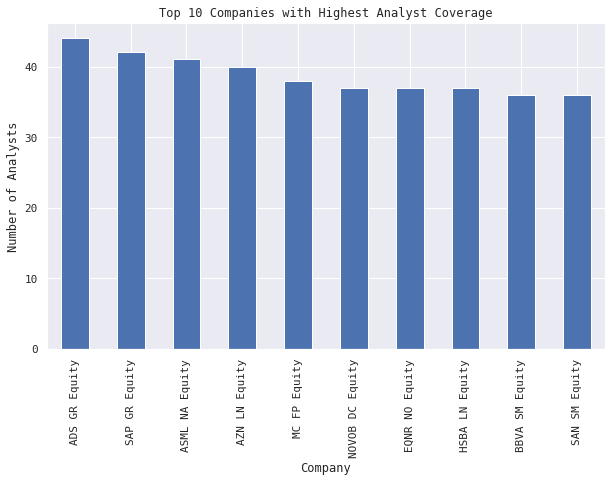

The company with the highest analyst coverage is 'ADS GR Equity' with 44 analysts covering it.


In [48]:
# Calculate the analyst coverage for each company
df_coverage = df[['BBTICKER', 'ANALYST']].copy()
df_coverage = df_coverage.drop_duplicates()
company_coverage = df_coverage['BBTICKER'].value_counts()

# Plot the top 10 companies with the highest analyst coverage
top_10_company_coverage = company_coverage.head(10)

plt.figure(figsize=(10, 6))
top_10_company_coverage.plot(kind='bar')
plt.title('Top 10 Companies with Highest Analyst Coverage')
plt.xlabel('Company')
plt.ylabel('Number of Analysts')
plt.show()

# Find the company with the highest analyst coverage
most_covered_company = company_coverage.idxmax()
most_covered_company_coverage = company_coverage.max()

print(f"The company with the highest analyst coverage is '{most_covered_company}' with {most_covered_company_coverage} analysts covering it.")


## 2. Which analyst covers the most companies?

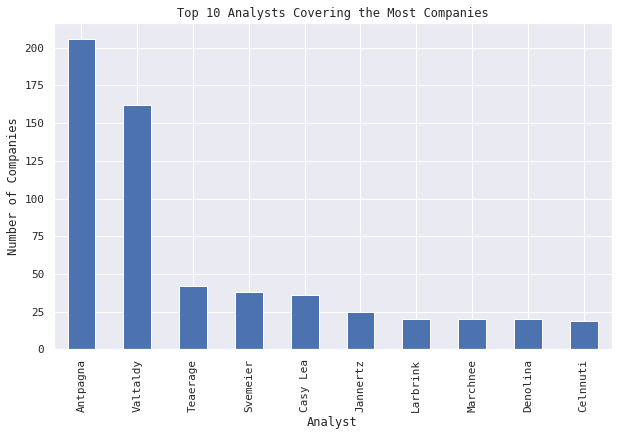

The analyst who covers the most companies is 'Antpagna' covering 206 different companies.


In [49]:
# Calculate the number of companies each analyst covers
# analyst_coverage = df.groupby('ANALYST')['BBTICKER'].nunique()
analyst_coverage = df_coverage['ANALYST'].value_counts()

# Plot the top 10 analysts covering the most companies
# top_10_analyst_coverage = analyst_coverage.sort_values(ascending=False).head(10)
top_10_analyst_coverage = analyst_coverage.head(10)

plt.figure(figsize=(10, 6))
top_10_analyst_coverage.plot(kind='bar')

plt.title('Top 10 Analysts Covering the Most Companies')
plt.xlabel('Analyst')
plt.ylabel('Number of Companies')
plt.show()

# Find the analyst covering the most companies
most_companies_analyst = analyst_coverage.idxmax()
most_companies_coverage = analyst_coverage.max()

print(f"The analyst who covers the most companies is '{most_companies_analyst}' covering {most_companies_coverage} different companies.")


## 3. Similarity Matrix
Based on how analysts organize themselves into covering companies,
### a. Could you model the similarity or conversely, the distance matrix between the companies based on this analyst co-coverage


In [42]:
categorical_features_ordinal = []
categorical_features_one_hot = ['BROKER', 'GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME', 'RECOMMENDATION']
numerical_features = ['RATING', 'TARGET_PRICE']
clean_pipeline = get_pipeline_clean_encode_only(categorical_features_one_hot, categorical_features_ordinal, numerical_features)

# We only want to observe analyst 'Antpagna'
df_preprocessed = clean_pipeline.fit_transform(df[df["ANALYST"] == "Antpagna"].reset_index(drop=True).copy())
cols = df[df["ANALYST"] == "Antpagna"]["BBTICKER"].tolist().copy()


#### Distance Matrix using corr

Shape of the similarity matrix: (206, 206)


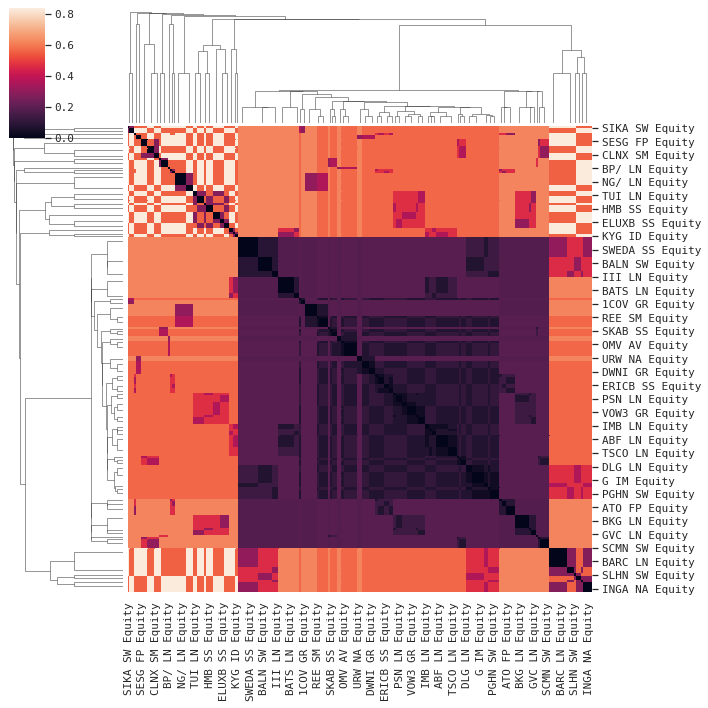

In [45]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

sns.set(font="monospace")

df_preprocessed_corr = df_preprocessed.T.corr()
df_preprocessed_corr.index = cols
df_preprocessed_corr.columns = cols

DF_dism = 1 - df_preprocessed_corr   # distance matrix

print("Shape of the similarity matrix:", df_preprocessed_corr.shape)
linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage)

Shape of the similarity matrix: (360, 360)


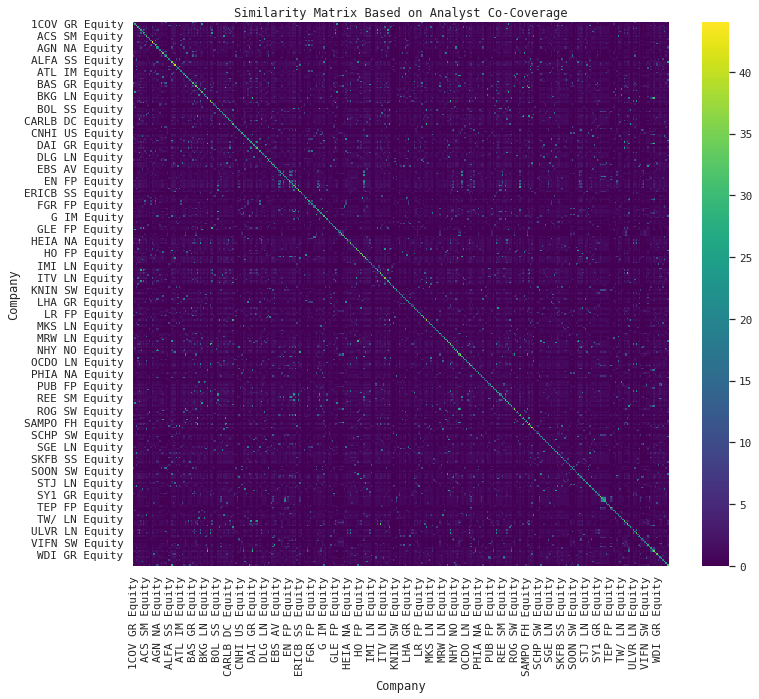

In [44]:
# Create a pivot table where rows are analysts and columns are companies
pivot_table = df.pivot_table(index='ANALYST', columns='BBTICKER', aggfunc='size', fill_value=0)

# Compute the similarity matrix (dot product of pivot table with its transpose)
similarity_matrix = np.dot(pivot_table.T, pivot_table)

# Convert to DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, index=pivot_table.columns, columns=pivot_table.columns)
similarity_df
# Print the shape of the similarity matrix
print("Shape of the similarity matrix:", similarity_df.shape)

# Plot the similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, cmap='viridis')
plt.title('Similarity Matrix Based on Analyst Co-Coverage')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


### b. How would the results change if you were to restrict the dataset to only analysts having companies covered within 1s.d. of the distribution found in Qn. 2?
- c. If further restricted to a smaller subset?

In [50]:
analyst_coverage

Antpagna    206
Valtaldy    162
Teaerage     42
Svemeier     38
Casy Lea     36
           ... 
ClaAlmer      1
Kriankar      1
Lenhuyse      1
Mehseini      1
Suzuizen      1
Name: ANALYST, Length: 2065, dtype: int64

Shape of the filtered similarity matrix: (360, 360)


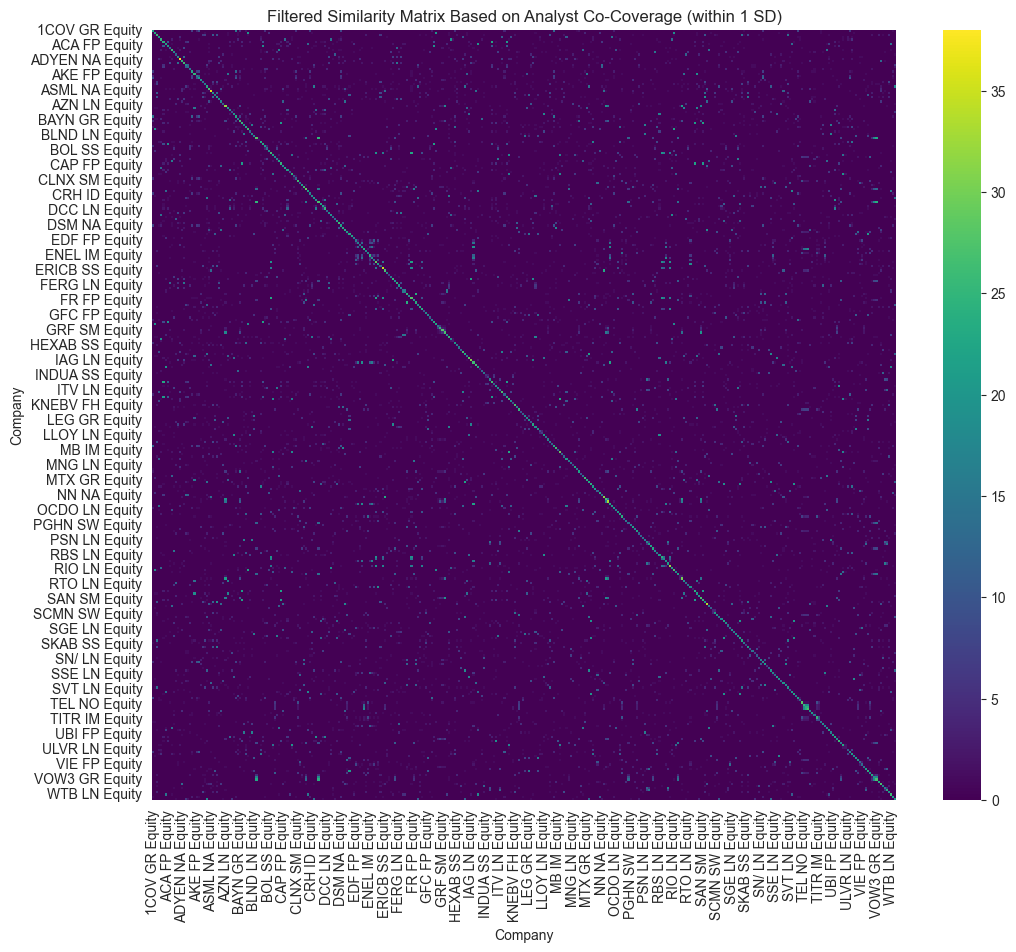

In [12]:
# Calculate the mean and standard deviation of the number of companies covered by each analyst
mean_coverage = analyst_coverage.mean()
std_dev_coverage = analyst_coverage.std()

# Filter analysts who cover companies within 1 standard deviation of the mean
filtered_analysts = analyst_coverage[(analyst_coverage >= mean_coverage - std_dev_coverage) & 
                                     (analyst_coverage <= mean_coverage + std_dev_coverage)].index

# Filter the dataframe to only include the filtered analysts
filtered_df = df[df['ANALYST'].isin(filtered_analysts)]

# Create a pivot table for the filtered analysts
filtered_pivot_table = filtered_df.pivot_table(index='ANALYST', columns='BBTICKER', aggfunc='size', fill_value=0)

# Compute the similarity matrix for the filtered data
filtered_similarity_matrix = np.dot(filtered_pivot_table.T, filtered_pivot_table)

# Convert to DataFrame for better visualization
filtered_similarity_df = pd.DataFrame(filtered_similarity_matrix, index=filtered_pivot_table.columns, columns=filtered_pivot_table.columns)

# Print the shape of the filtered similarity matrix
print("Shape of the filtered similarity matrix:", filtered_similarity_df.shape)

# Plot the filtered similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_similarity_df, cmap='viridis')
plt.title('Filtered Similarity Matrix Based on Analyst Co-Coverage (within 1 SD)')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


Shape of the selected similarity matrix: (18, 18)


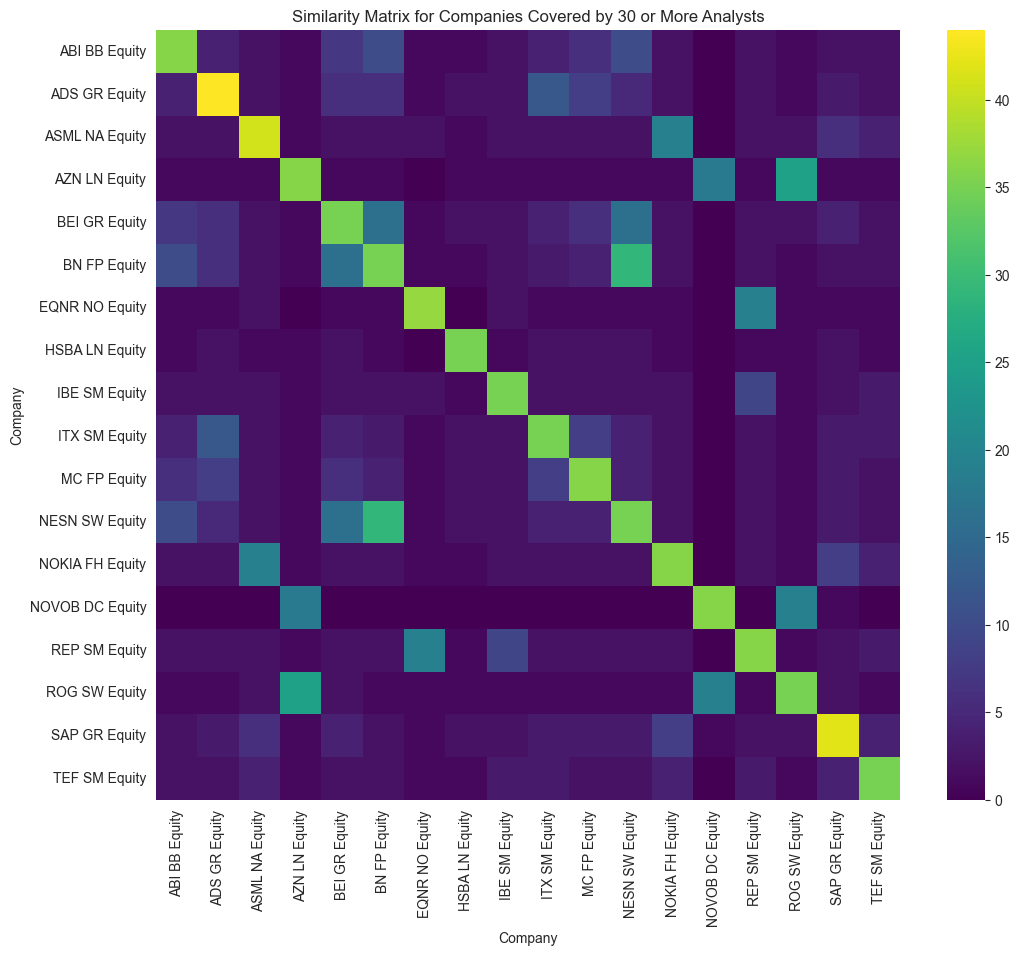

In [13]:
# Filter companies covered by 35 or more analysts
company_coverage = df['BBTICKER'].value_counts()
selected_companies = company_coverage[company_coverage >= 35].index

# Filter the dataframe to only include the selected companies
selected_df = df[df['BBTICKER'].isin(selected_companies)]

# Create a pivot table for the selected companies
selected_pivot_table = selected_df.pivot_table(index='ANALYST', columns='BBTICKER', aggfunc='size', fill_value=0)

# Compute the similarity matrix for the selected companies
selected_similarity_matrix = np.dot(selected_pivot_table.T, selected_pivot_table)

# Convert to DataFrame for better visualization
selected_similarity_df = pd.DataFrame(selected_similarity_matrix, index=selected_pivot_table.columns, columns=selected_pivot_table.columns)

# Print the shape of the selected similarity matrix
print("Shape of the selected similarity matrix:", selected_similarity_df.shape)

# Plot the selected similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(selected_similarity_df, cmap='viridis')
plt.title('Similarity Matrix for Companies Covered by 30 or More Analysts')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()
